# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import statsmodels.formula.api as smf

In [3]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    float64
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(11), int64(2), object(2)
memory usage: 35.6+ KB


1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [5]:
def gerar_bivariada(df, target, feature):
    # Verifica se variável explicativa é numérica → se sim, categoriza em 5 grupos
    if pd.api.types.is_numeric_dtype(df[feature]):
        df['_temp_group'] = pd.qcut(df[feature], q=5, duplicates='drop')
    else:
        df['_temp_group'] = df[feature]

    # Monta a tabela cruzada
    bivariada = pd.crosstab(df['_temp_group'], df[target])
    if 0 not in bivariada.columns:
        bivariada[0] = 0
    if 1 not in bivariada.columns:
        bivariada[1] = 0
    bivariada.columns = ['saudaveis', 'doentes']
    bivariada['total'] = bivariada['saudaveis'] + bivariada['doentes']
    bivariada['media_doentes'] = bivariada['doentes'] / bivariada['total']
    bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis'].replace(0, np.nan)

    # Odds total
    total_doentes = df[target].sum()
    total_saudaveis = (df[target] == 0).sum()
    odds_total = total_doentes / total_saudaveis

    # Odds ratio, logito e WOE
    bivariada['odds_ratio'] = bivariada['odds'] / odds_total
    bivariada['logito'] = np.log(bivariada['odds'].replace(0, np.nan))
    bivariada['woe'] = np.log(bivariada['odds_ratio'].replace(0, np.nan))

    # Valor médio da feature (se for numérica)
    if pd.api.types.is_numeric_dtype(df[feature]):
        media_feature = df.groupby('_temp_group')[feature].mean()
        bivariada['media_' + feature] = media_feature

    bivariada.index.name = feature
    return bivariada

In [6]:
# Adiciona variável binária de doença
df['flag_doente'] = (df['num'] != 0).astype(int)

# 1. SEX
biv_sex = gerar_bivariada(df, target='flag_doente', feature='sex')
print("Bivariada - SEX\n", biv_sex, "\n")

# 2. CP (chest pain type)
biv_cp = gerar_bivariada(df, target='flag_doente', feature='cp')
print("Bivariada - CP\n", biv_cp, "\n")

# 3. SLOPE (inclinação ST)
biv_slope = gerar_bivariada(df, target='flag_doente', feature='slope')
print("Bivariada - SLOPE\n", biv_slope, "\n")

Bivariada - SEX
                saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
sex                                                                             
(-0.001, 1.0]        164      139    303       0.458746  0.847561         1.0   

                 logito  woe  media_sex  
sex                                      
(-0.001, 1.0] -0.165392  0.0   0.679868   

Bivariada - CP
               saudaveis  doentes  total  media_doentes      odds  odds_ratio  \
cp                                                                             
(0.999, 2.0]         57       16     73       0.219178  0.280702    0.331188   
(2.0, 3.0]           68       18     86       0.209302  0.264706    0.312315   
(3.0, 4.0]           39      105    144       0.729167  2.692308    3.176536   

                logito       woe  media_cp  
cp                                          
(0.999, 2.0] -1.270463 -1.105070  1.684932  
(2.0, 3.0]   -1.329136 -1.163743  3.000000  
(3.0, 4.0]    

C:\Users\coimb\AppData\Local\Temp\ipykernel_23832\92692322.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_feature = df.groupby('_temp_group')[feature].mean()
C:\Users\coimb\AppData\Local\Temp\ipykernel_23832\92692322.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_feature = df.groupby('_temp_group')[feature].mean()
C:\Users\coimb\AppData\Local\Temp\ipykernel_23832\92692322.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default 

### ✅ Conclusão

Após aplicar a análise bivariada às variáveis `sex`, `cp` e `slope`, observamos que a variável **`cp` (tipo de dor no peito)** apresenta a **melhor discriminação do risco de doença cardíaca**. 

Isso se evidencia pela **maior variação nos valores de Weight of Evidence (WOE)** e na **proporção de doentes entre suas categorias**.

Essa amplitude de WOE indica que os diferentes tipos de dor no peito estão fortemente associados à presença ou ausência de doença, tornando `cp` uma variável altamente informativa para fins de modelagem preditiva ou diagnóstico clínico.

✅ Portanto, entre as variáveis analisadas, `cp` é a que **mais contribui para diferenciar** pacientes saudáveis dos doentes.


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [7]:
def gerar_bivariada_continua(df, target, feature, n_grupos=5):
    # Categorização em quantis
    df['_temp_group'] = pd.qcut(df[feature], q=n_grupos, duplicates='drop')

    # Tabela cruzada com saudáveis e doentes
    bivariada = pd.crosstab(df['_temp_group'], df[target])
    if 0 not in bivariada.columns:
        bivariada[0] = 0
    if 1 not in bivariada.columns:
        bivariada[1] = 0
    bivariada.columns = ['saudaveis', 'doentes']
    bivariada['total'] = bivariada['saudaveis'] + bivariada['doentes']
    bivariada['media_doentes'] = bivariada['doentes'] / bivariada['total']
    bivariada['odds'] = bivariada['doentes'] / bivariada['saudaveis'].replace(0, np.nan)

    # Cálculo da odds total
    total_doentes = df[target].sum()
    total_saudaveis = (df[target] == 0).sum()
    odds_total = total_doentes / total_saudaveis

    # Odds ratio, logito, WOE
    bivariada['odds_ratio'] = bivariada['odds'] / odds_total
    bivariada['logito'] = np.log(bivariada['odds'].replace(0, np.nan))
    bivariada['woe'] = np.log(bivariada['odds_ratio'].replace(0, np.nan))

    # Valor médio da variável contínua em cada grupo
    media_feature = df.groupby('_temp_group')[feature].mean()
    bivariada['media_' + feature] = media_feature

    bivariada.index.name = feature + '_group'
    return bivariada

In [8]:
bivariada_age = gerar_bivariada_continua(df, target='flag_doente', feature='age', n_grupos=5)
display(bivariada_age)

C:\Users\coimb\AppData\Local\Temp\ipykernel_23832\3264601919.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  media_feature = df.groupby('_temp_group')[feature].mean()


,saudaveis,doentes,total,media_doentes,odds,odds_ratio,logito,woe,media_age
age_group,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166,41.222222
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235,50.000000
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218,56.211268
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179,60.355556
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392,66.516667


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [10]:
import statsmodels.formula.api as smf
# Categorize trestbps em 4 grupos (quantis ou faixas)
df['trestbps_cat'] = pd.qcut(df['trestbps'], q=4, duplicates='drop')

# Agora, use essa versão categorizada no modelo
formula = 'flag_doente ~ C(sex) + C(cp) + age + C(trestbps_cat)'
modelo = smf.logit(formula=formula, data=df).fit()
print(modelo.summary())

Optimization terminated successfully.
         Current function value: 0.478951
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.3056
Time:                        23:42:21   Log-Likelihood:                -145.12
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 8.324e-24
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept     

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor eperado versus observado para a taxa de maus por grupo

   grupo_prob  prob_predita_media  taxa_evento_observada   n
0           0            0.072102               0.065574  61
1           1            0.212889               0.166667  60
2           2            0.432514               0.491803  61
3           3            0.701333               0.733333  60
4           4            0.874837               0.836066  61


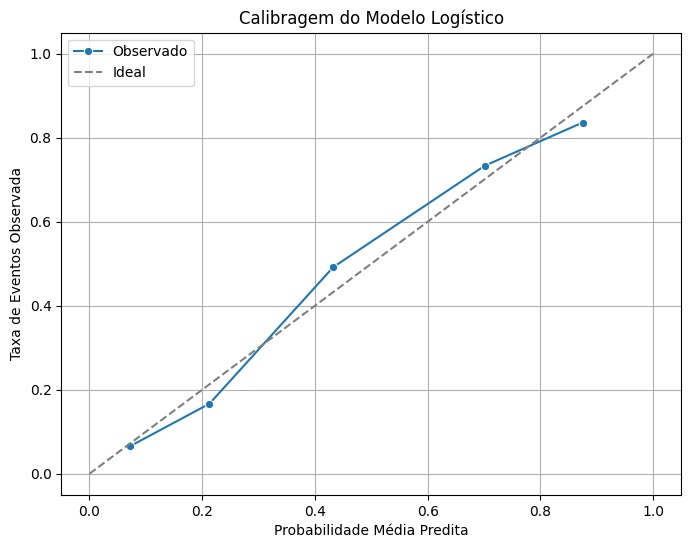

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Supondo que 'modelo' já esteja ajustado (exemplo abaixo, caso não esteja):
# formula = 'flag_doente ~ C(sex) + C(cp) + age + trestbps'
# modelo = smf.logit(formula=formula, data=df).fit()

# 1. Calcular probabilidade predita pelo modelo
df['prob_predita'] = modelo.predict(df)

# 2. Categorizar a probabilidade predita em 5 grupos (quantis)
df['grupo_prob'] = pd.qcut(df['prob_predita'], q=5, labels=False)

# 3. Calcular probabilidade predita média e taxa de eventos observada por grupo
calibragem = df.groupby('grupo_prob').agg(
    prob_predita_media = ('prob_predita', 'mean'),
    taxa_evento_observada = ('flag_doente', 'mean'),
    n = ('flag_doente', 'size')
).reset_index()

print(calibragem)

# 4. Gráfico comparando valor esperado (médio predito) vs observado (taxa real)
plt.figure(figsize=(8,6))
sns.lineplot(data=calibragem, x='prob_predita_media', y='taxa_evento_observada', marker='o', label='Observado')
plt.plot([0,1],[0,1], '--', color='gray', label='Ideal')
plt.xlabel('Probabilidade Média Predita')
plt.ylabel('Taxa de Eventos Observada')
plt.title('Calibragem do Modelo Logístico')
plt.legend()
plt.grid(True)
plt.show()

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

In [12]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

# (1) Definir predição binária com cutoff 0.5
df['pred_class'] = (df['prob_predita'] >= 0.5).astype(int)

# (2) Calcular acurácia
acuracia = accuracy_score(df['flag_doente'], df['pred_class'])

# (3) Calcular AUC-ROC
auc = roc_auc_score(df['flag_doente'], df['prob_predita'])

# (4) Calcular GINI a partir do AUC
gini = 2 * auc - 1

# (5) Calcular KS
fpr, tpr, thresholds = roc_curve(df['flag_doente'], df['prob_predita'])
ks = max(tpr - fpr)

# Resultados
print(f'Acurácia (cutoff 0.5): {acuracia:.4f}')
print(f'AUC-ROC: {auc:.4f}')
print(f'GINI: {gini:.4f}')
print(f'KS: {ks:.4f}')

Acurácia (cutoff 0.5): 0.7789
AUC-ROC: 0.8507
GINI: 0.7014
KS: 0.5812


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

Optimization terminated successfully.
         Current function value: 0.452772
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      294
Method:                           MLE   Df Model:                            8
Date:                Tue, 17 Jun 2025   Pseudo R-squ.:                  0.3436
Time:                        23:43:52   Log-Likelihood:                -137.19
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 4.223e-27
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -9.1899      1.798     -5.110      0.000     -12.715      -5.665
C(sex)[T.1.0] 

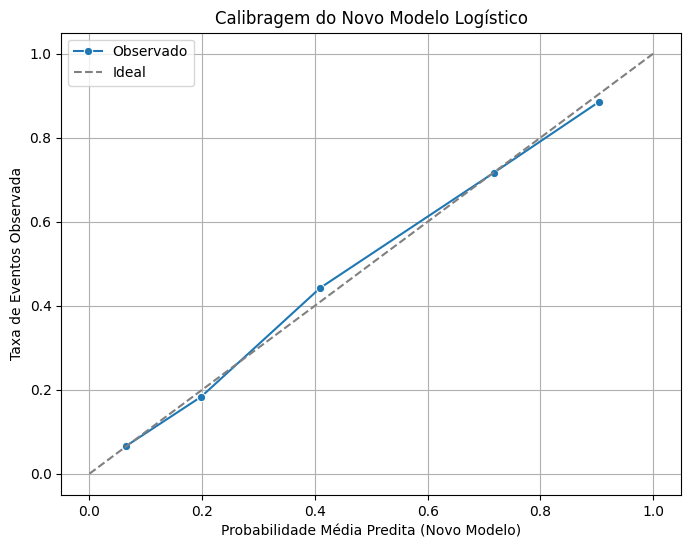

In [13]:
# Nova fórmula incluindo 'chol' e 'exang'
formula_novo = 'flag_doente ~ C(sex) + C(cp) + age + trestbps + chol + C(exang)'

# Ajustar o modelo com novas variáveis
modelo_novo = smf.logit(formula=formula_novo, data=df).fit()

print(modelo_novo.summary())

# Previsões com novo modelo
df['prob_predita_novo'] = modelo_novo.predict(df)
df['pred_class_novo'] = (df['prob_predita_novo'] >= 0.5).astype(int)

# Avaliar acurácia do novo modelo
from sklearn.metrics import accuracy_score
acuracia_novo = accuracy_score(df['flag_doente'], df['pred_class_novo'])
print(f'Acurácia do modelo novo (cutoff 0.5): {acuracia_novo:.4f}')

# Avaliação da calibragem do novo modelo
df['grupo_prob_novo'] = pd.qcut(df['prob_predita_novo'], q=5, labels=False)
calibragem_novo = df.groupby('grupo_prob_novo').agg(
    prob_predita_media=('prob_predita_novo', 'mean'),
    taxa_evento_observada=('flag_doente', 'mean'),
    n=('flag_doente', 'size')
).reset_index()

print(calibragem_novo)

# Gráfico de calibragem do novo modelo
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.lineplot(data=calibragem_novo, x='prob_predita_media', y='taxa_evento_observada', marker='o', label='Observado')
plt.plot([0,1],[0,1], '--', color='gray', label='Ideal')
plt.xlabel('Probabilidade Média Predita (Novo Modelo)')
plt.ylabel('Taxa de Eventos Observada')
plt.title('Calibragem do Novo Modelo Logístico')
plt.legend()
plt.grid(True)
plt.show()